In [2]:
import numpy as np
import pandas as pd
import plotly.graph_objects as pgo
import plotly.subplots as ps
import plotly.express as px

from tqdm.notebook import tqdm
from collections import Counter

from datapaths import *

pd.set_option('display.max_rows', 4)


In [3]:
flipon_to_data = pd.read_table(F_FLIPON_TO_DATA)
flipon_to_data

,Flipon,Coordinates,Strand,Gene Feature,Gene Name,Gene Strand,Gene Type,Gene ID,Transcript ID,c. M miR (+),...,c. J miR (-),all M miR (+),all M miR (-),all MJ miR (+),all MJ miR (-),all J miR (+),all J miR (-),cCRE (+-200bp),LINE/LTR (+-200bp),Feature Group
0,g4,chr1:3014794-3014871,-,Distal Intergenic,4933401J01Rik,+,TEC,ENSMUSG00000102693.1,ENSMUST00000193812.1,miR-328 (1),...,NaN,"miR-6994 (1), miR-129b (1)","miR-92a-2 (1), miR-698/miR-7078 (1), miR-3572 ...",miR-486a/miR-486b (1),"miR-3076 (1), miR-6418 (1), miR-6987 (1)",NaN,miR-7649 (1),NaN,"LINE@L1Md_F2(-), LINE@L1VL1(+)",LINE/LTR
1,g4,chr1:3099888-3099963,+,Promoter (2-3kb),Gm26206,+,snRNA,ENSMUSG00000064842.1,ENSMUST00000082908.1,NaN,...,NaN,"miR-365-1/miR-365-2 (1), miR-698/miR-7078 (1),...","miR-221 (1), miR-129b (1)","miR-6418 (1), miR-7067 (1)",NaN,NaN,NaN,NaN,"LINE@L1Md_F2(+), LTR@MTC(+)",LINE/LTR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77706,z-dna,chrY:4203100-4203146,.,Distal Intergenic,Gm28191,+,unprocessed_pseudogene,ENSMUSG00000100300.1,ENSMUST00000189112.1,NaN,...,NaN,"miR-466d/miR-466i (4), miR-466l (5)",NaN,miR-493 (1),NaN,NaN,NaN,NaN,LINE@L1_Mur1(-),LINE/LTR
77707,z-dna,chrY:4207093-4207113,.,Distal Intergenic,Gm28191,+,unprocessed_pseudogene,ENSMUSG00000100300.1,ENSMUST00000189112.1,NaN,...,NaN,"miR-466a/miR-466e/miR-466p (1), miR-466d/miR-4...",NaN,NaN,NaN,NaN,NaN,NaN,"LINE@L1_Mus3(+), LINE@L1Md_A(+), LTR@ORR1B1(+)",LINE/LTR


In [4]:
c_mir_df = pd.read_table(F_MIRNA_LIST_CONSERVED)
c_mir_df

,miRNA gene family,Seed region,Seed region (RC)
0,let-7/miR-98,['GAGGTAG'],['CTACCTC']
1,miR-1/206,['GGAATGT'],['ACATTCC']
...,...,...,...
175,miR-1249,['CGCCCTT'],['AAGGGCG']
176,miR-1298,['TCATTCG'],['CGAATGA']


In [5]:
c_mir_list = ['c. M miR (+)', 'c. M miR (-)', 'c. MJ miR (+)', 'c. MJ miR (-)', 'c. J miR (+)', 'c. J miR (-)']

form_df_t = flipon_to_data[
    (flipon_to_data["Gene Feature"] == "Promoter (<=1kb)")
    & (
        (
            flipon_to_data["Feature Group"].isin(
                ["cCRE", "cCRE & CTCF", "LINE/LTR", "LINE/LTR & CTCF"]
            )
        )
    )
][['Flipon', *c_mir_list, 'Gene Strand', 'Feature Group']]

form_df_t['Feature Group'] = form_df_t['Feature Group'].str.replace(' & CTCF', '')
form_df_t[c_mir_list] = form_df_t[c_mir_list].apply(lambda col: col.str.split(', '))
form_df_t

,Flipon,c. M miR (+),c. M miR (-),c. MJ miR (+),c. MJ miR (-),c. J miR (+),c. J miR (-),Gene Strand,Feature Group
7,g4,NaN,NaN,[miR-423 (1)],NaN,NaN,NaN,-,cCRE
15,g4,NaN,NaN,NaN,NaN,NaN,NaN,-,cCRE
...,...,...,...,...,...,...,...,...,...
77673,z-dna,NaN,[miR-744 (1)],NaN,NaN,NaN,NaN,+,cCRE
77677,z-dna,[miR-96/1271 (1)],NaN,NaN,NaN,NaN,NaN,-,cCRE


In [6]:
mir_counter = Counter()
for _, row in tqdm(form_df_t.iterrows(), total=form_df_t.shape[0]):
    for idx, cell in zip(row.index, row):
        if type(cell) == list:
            for mir in cell:
                mir_name = mir.split(' (')[0]
                mir_count = int(mir.split(' (')[1][:-1])
                mir_sign = idx.split(' (')[1][0]
                mir_codirection = 'Same strand' if mir_sign == row['Gene Strand'] else 'Different strand'
                mir_counter[(mir_name, row['Flipon'], row['Feature Group'], mir_codirection)] += mir_count
# form_df_t.filter(like='c. ').apply(lambda col: col.str.split(', '))

  0%|          | 0/17016 [00:00<?, ?it/s]

In [7]:
def get_data_from_counter(counter: Counter) -> pd.DataFrame():
    counter = Counter({key: val for key, val in counter.items() if val != 0})
    keys, values = zip(*counter.items())
    mir_family, flipon, feature_group, strand_direction = zip(*keys)

    result = (
        pd.DataFrame(
            {
                'miRNA gene family': mir_family,
                "Flipon": flipon,
                "Feature group": feature_group,
                "Strand direction": strand_direction,
                "Count": values,
            }
        )
    )
    return result

mir_count_df = get_data_from_counter(mir_counter)
mir_count_df['Count signed'] = mir_count_df['Count'] * (mir_count_df['Strand direction'] == 'Same strand').astype(int).replace(0, -1)

# with pd.option_context('display.max_rows', None):
#     mir_count_df = mir_count_df[mir_count_df['miRNA gene family'] == 'let-7/miR-98']

display(mir_count_df)

,miRNA gene family,Flipon,Feature group,Strand direction,Count,Count signed
0,miR-423,g4,cCRE,Different strand,246,-246
1,miR-150,g4,LINE/LTR,Different strand,6,-6
...,...,...,...,...,...,...
1408,miR-23,z-dna,cCRE,Same strand,1,1
1409,miR-142,z-dna,cCRE,Same strand,1,1


In [8]:
# with pd.option_context("display.max_rows", None, "display.max_columns", None):
#     display(
#         flipon_to_data[
#             (flipon_to_data["Gene Feature"] == "Promoter (<=1kb)")
#             & (
#                 flipon_to_data["Feature Group"].isin(
#                     ["cCRE & CTCF", "LINE/LTR & CTCF", "cCRE", "LINE/LTR"]
#                 )
#             )
#             & (
#                 flipon_to_data["c. miR (+)"].str.contains(
#                     "let-7/miR-98 (", regex=False, na=False
#                 )
#                 | flipon_to_data["c. miR (-)"].str.contains(
#                     "let-7/miR-98 (", regex=False, na=False
#                 )
#             )
#         ]
#     )


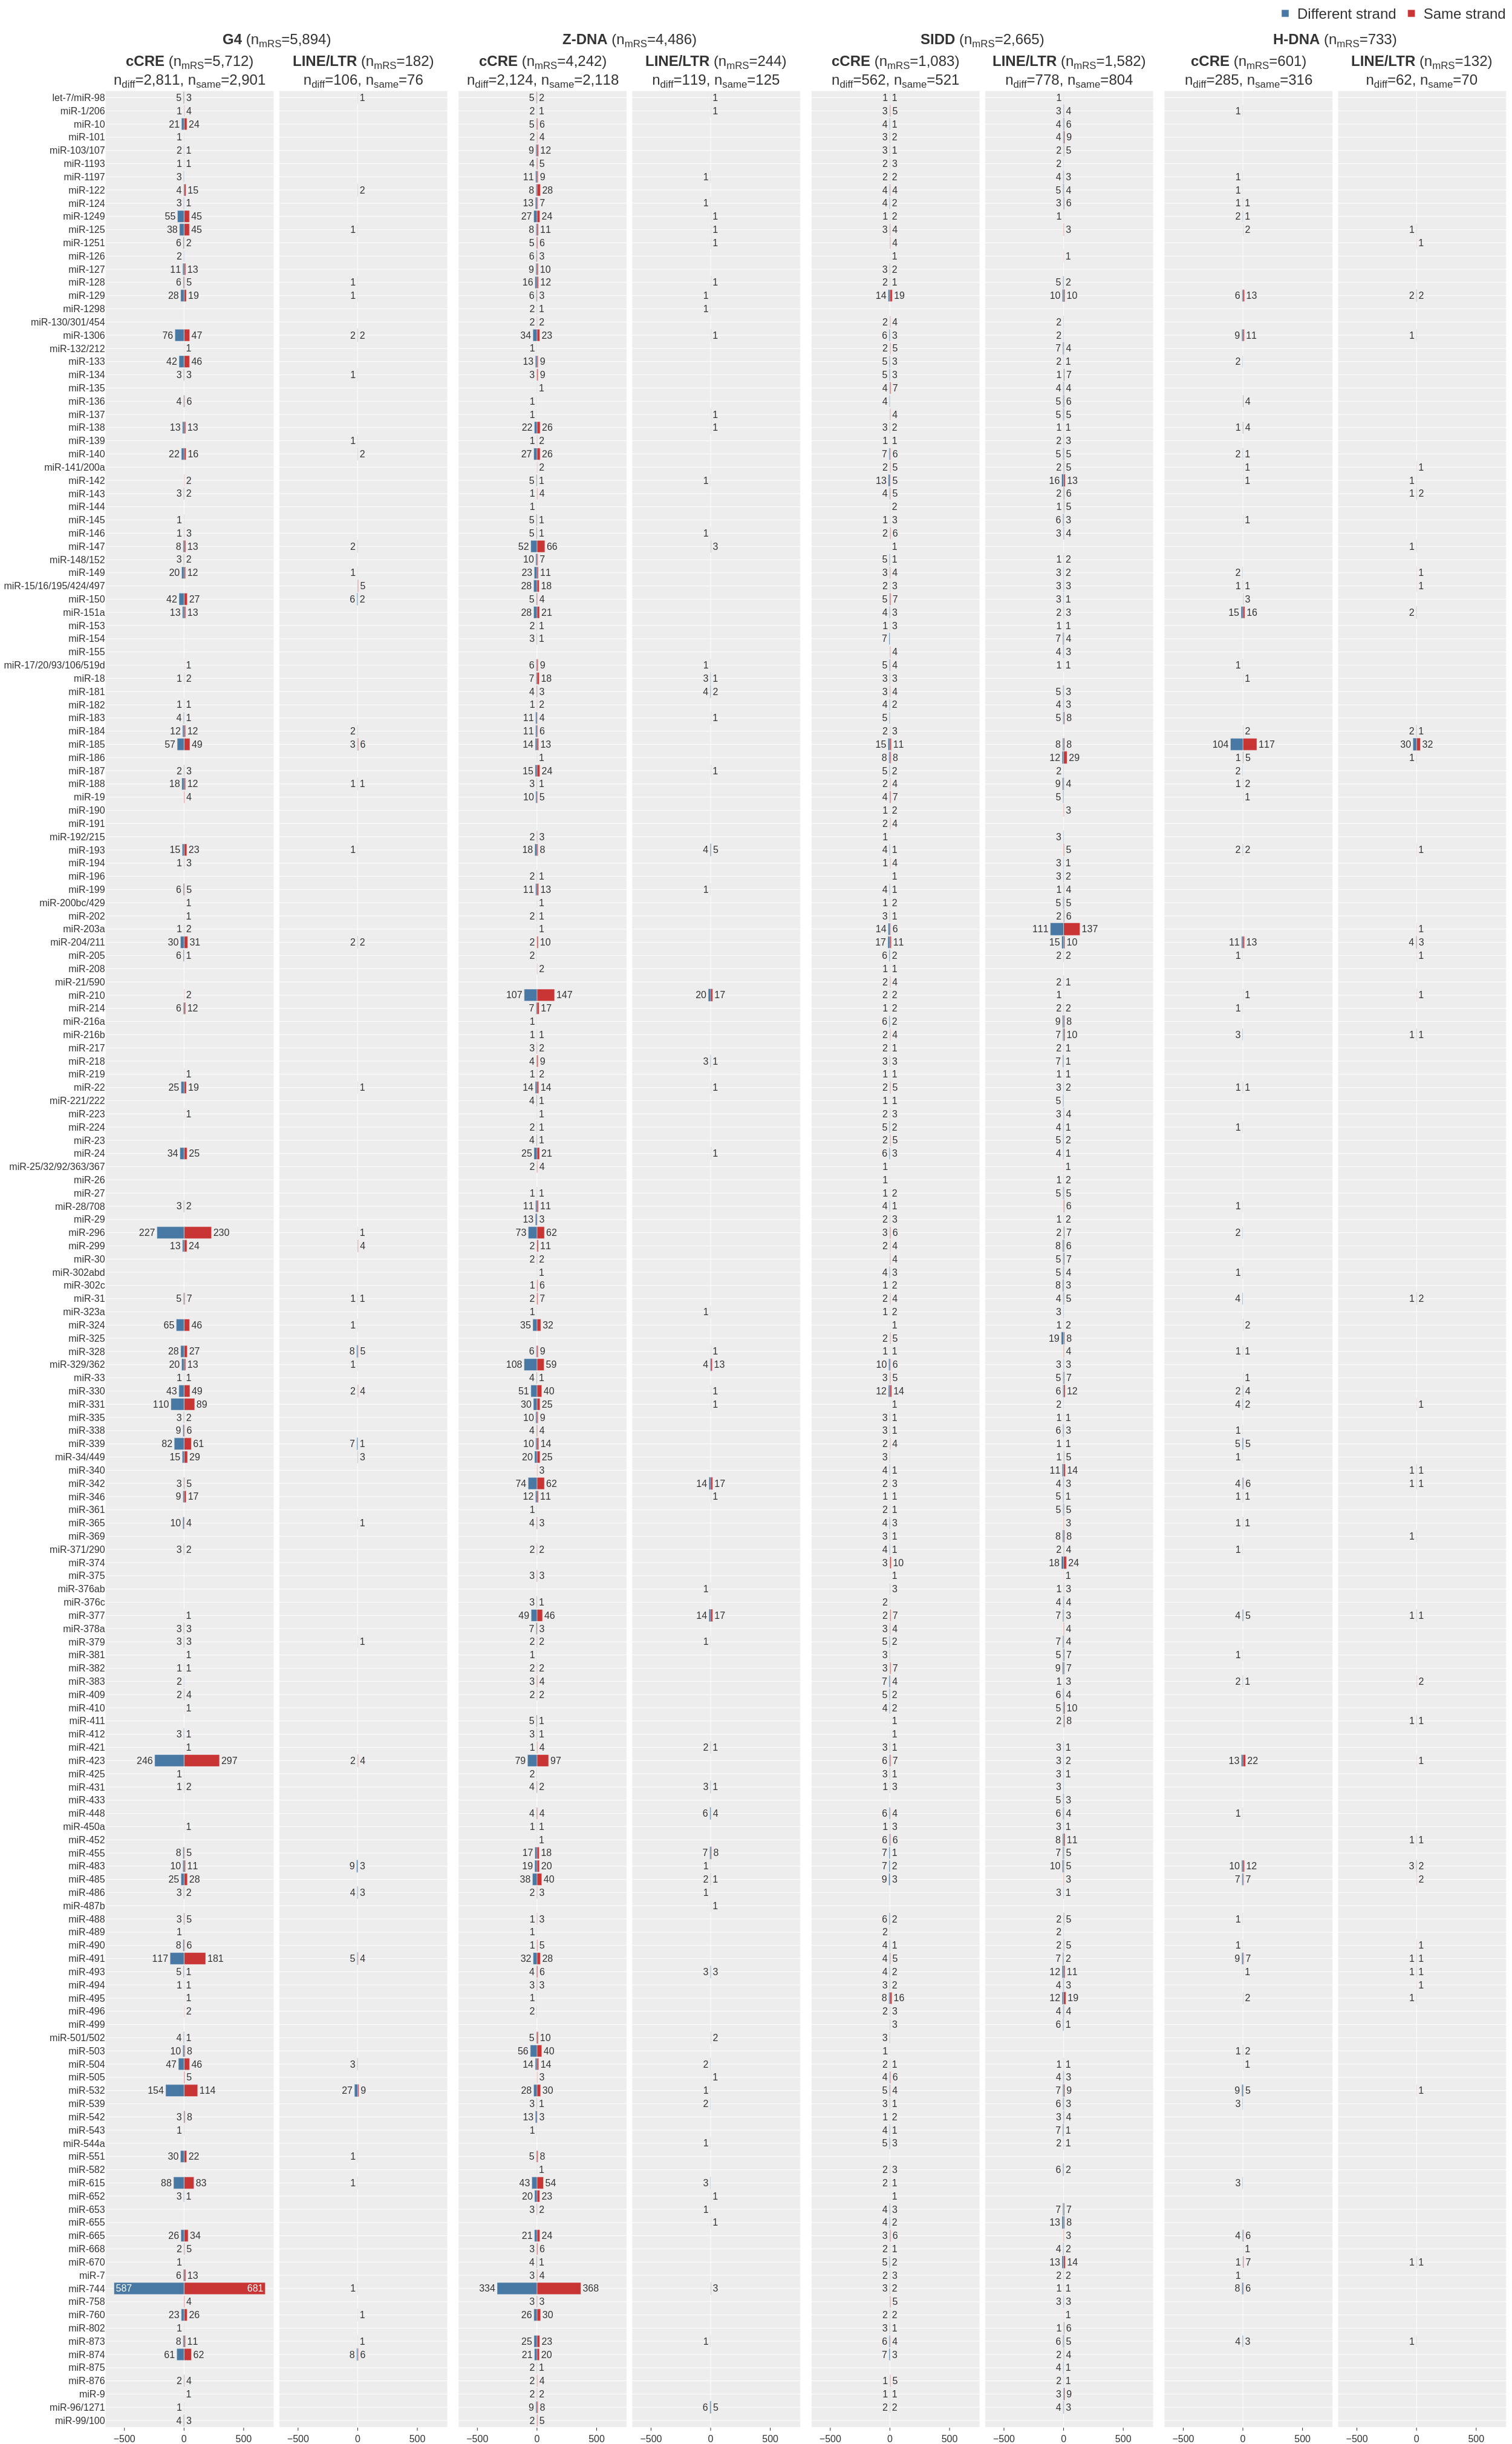

In [9]:
flipon_types = ["g4", "z-dna", "sidd", "h-dna"]
categories_ccre = [
    ("cCRE", "Same strand"),
    ("cCRE", "Different strand"),
]
categories_rmsk = [
    ("LINE/LTR", "Same strand"),
    ("LINE/LTR", "Different strand"),
]
colors = {
    "Same strand": COLORS['SIDD'],
    "Different strand": COLORS['Z-DNA']
}

n_rows = 2
n_cols = 8

subplot_titles = [
    f"<b>{flipon.upper()}</b> (n<sub>mRS</sub>={mir_count_df[mir_count_df['Flipon']==flipon]['Count'].sum():,d})"
    for flipon in flipon_types
]
for flipon in flipon_types:
    for feature_group, _ in [categories_ccre[0], categories_rmsk[0]]:
        counts_same = mir_count_df[
            (mir_count_df["Flipon"] == flipon) & (mir_count_df["Feature group"]== feature_group) & (mir_count_df['Strand direction']=='Same strand')
        ]["Count"]
        counts_diff = mir_count_df[
            (mir_count_df["Flipon"] == flipon) & (mir_count_df["Feature group"]== feature_group) & (mir_count_df['Strand direction']=='Different strand')
        ]["Count"]
        subplot_titles.append(f"<b>{feature_group}</b> (n<sub>mRS</sub>={counts_same.sum() + counts_diff.sum():,d})<br>n<sub>diff</sub>={counts_diff.sum():,d}, n<sub>same</sub>={counts_same.sum():,d}")

specs = [
    [
        {"colspan": 2},
        None,
        {"colspan": 2},
        None,
        {"colspan": 2},
        None,
        {"colspan": 2},
        None,
    ],
    [{'l':0.002}, {'r':0.002}, {'l':0.002}, {'r':0.002}, {'l':0.002}, {'r':0.002}, {'l':0.002}, {'r':0.002}],
]

fig = ps.make_subplots(
    rows=n_rows,
    cols=n_cols,
    shared_xaxes="all",
    shared_yaxes="all",
    horizontal_spacing=0.004,
    vertical_spacing=0.01,
    subplot_titles=subplot_titles,
    specs=specs,
    row_heights=[.007, .993],
    # y_title="Number of miRNAs per flipon",
    # x_title="Flipon count",
)

for i, flipon in enumerate(flipon_types):
    for category, strand_direction in categories_ccre:
        df = mir_count_df[
            (mir_count_df["Flipon"] == flipon)
            & (mir_count_df["Feature group"] == category)
            & (mir_count_df['Strand direction'] == strand_direction)
        ]
        sub = pgo.Bar(
            x=df["Count signed"],
            y=df["miRNA gene family"],
            text=df["Count"],
            name=strand_direction,
            texttemplate="%{text:,d}",
            textposition=df["Count"].apply(
                lambda x: "outside" if abs(x) <= mir_count_df['Count'].max()/1.5 else "inside"
            ),
            cliponaxis=False,
            marker=dict(color=colors[strand_direction]),
            orientation="h",
            width=0.9,
            showlegend=True if (i == 0) else False,
        )
        fig.add_trace(sub, row=2, col=2 * i + 1)
    for category, strand_direction in categories_rmsk:
        df =  mir_count_df[
            (mir_count_df["Flipon"] == flipon)
            & (mir_count_df["Feature group"] == category)
            & (mir_count_df['Strand direction'] == strand_direction)
        ]
        sub = pgo.Bar(
            x=df["Count signed"],
            y=df["miRNA gene family"],
            text=df["Count"],
            name=strand_direction,
            texttemplate="%{text:,d}",
            textposition=df["Count"].apply(
                lambda x: "outside" if abs(x) <= mir_count_df['Count'].max()/1.5 else "inside"
            ),
            cliponaxis=False,
            marker=dict(color=colors[strand_direction]),
            orientation="h",
            width=0.95,
            showlegend=False,
        )
        fig.add_trace(sub, row=2, col=2 * i + 2)

fig.update_xaxes(tickformat="s", showgrid=False)
fig.update_yaxes(
    ticks="",
    type="category",
    categoryarray=mir_count_df.sort_values("miRNA gene family", ascending=False)["miRNA gene family"].unique(),
    categoryorder="array",
)
fig.update_annotations(font=dict(size=24))

fig.update_layout(
    # title="<span style='font-size: 28px;'>Number of sites bound by each conserved miR by DNA strand (M+MJ+J)</span>",
    title_x=0.005,
    title_y=0.998,
    height=500 + mir_count_df['miRNA gene family'].nunique() * 20,
    width=2500,
    barmode="relative",
    font=dict(size=16),
    uniformtext_minsize=16,
    uniformtext_mode="show",
    margin=dict(t=0, r=5, b=5, l=170),
    legend=dict(
        # title_text="Flipon group",
        # traceorder="reversed",
        font_size=24,
        orientation="h",
        yanchor="bottom",
        y=1.01,
        xanchor="right",
        x=1,
        traceorder='reversed',
    ),
    template="ggplot2",
)

fig.write_image(D_IMG / "Figure.4.png", scale=2.5)
fig.write_image(D_IMG / "Figure.4.pdf", scale=1)
fig.show(renderer='png')


In [9]:
# form_df_1 = (
#     flipon_to_data[
#         (flipon_to_data["Gene Feature"]=="Promoter (<=1kb)")
#         & flipon_to_data["cCRE (+-200bp)"].isna()
#         & flipon_to_data["LINE/LTR (+-200bp)"].notna()
#     ]
#     .replace(regex=" \(\d+\)", value="")
#     .assign(type="LINE/LTR w/o cCREs")
# )

# form_df_2 = (
#     flipon_to_data[
#         (flipon_to_data["Gene Feature"]=="Promoter (<=1kb)")
#         & flipon_to_data["cCRE (+-200bp)"].notna()
#         & flipon_to_data["LINE/LTR (+-200bp)"].isna()
#     ]
#     .replace(regex=" \(\d+\)", value="")
#     .assign(type="cCREs w/o LINE/LTR")
# )

# form_df = (
#     pd.concat([form_df_1, form_df_2], ignore_index=True)
#     .assign(
#         p=lambda x: x["c. miR (+)"].apply(lambda x: x.split(", ") if type(x) != float else None),
#         m=lambda x: x["c. miR (-)"].apply(lambda x: x.split(", ") if type(x) != float else None),
#         gene_strand=lambda x: x["Gene Strand"].apply(
#             lambda y: "p" if y == "+" else "m"
#         ),
#     )
#     .explode("p")
#     .explode("m")
#     .loc[:, ["type", "Gene Feature", "gene_strand", "Flipon", "p", "m"]]
#     .melt(
#         id_vars=["type", "Gene Feature", "gene_strand", "Flipon"],
#         value_vars=["p", "m"],
#         var_name="mirna_strand",
#         value_name="mirna",
#     )
#     .assign(
#         mirna_gene_strand_orientation=lambda x: x[
#             ["gene_strand", "mirna_strand"]
#         ].apply(lambda y: "Same strand" if y[0] == y[1] else "Different strand", axis=1)
#     )
#     .groupby(["mirna", "type", "Flipon"])[["mirna_gene_strand_orientation"]]
#     .value_counts()
#     .to_frame()
#     .rename(columns={0: "total_count"})
#     .reset_index()
#     .replace("", np.nan)
#     .dropna()
#     .sort_values(["mirna", "type", "Flipon"], ascending=[False, False, False])
#     .reset_index(drop=True)
# )

# form_df['total_count_signed'] = form_df.apply(lambda x: x.total_count if x.mirna_gene_strand_orientation=="Same strand" else -x.total_count, axis=1)
# form_df['custom_type'] = form_df['type'] + ", " + form_df['mirna_gene_strand_orientation']

# form_df


In [10]:
# groups = ["g4", "z-dna", "sidd", "h-dna"]
# categories_ccre = [
#     ("cCREs w/o LINE/LTR", "Same strand"),
#     ("cCREs w/o LINE/LTR", "Different strand"),
# ]
# categories_rmsk = [
#     ("LINE/LTR w/o cCREs", "Same strand"),
#     ("LINE/LTR w/o cCREs", "Different strand"),
# ]
# colors = {
#     "Same strand": COLORS['SIDD'],
#     "Different strand": COLORS['Z-DNA']
# }

# n_rows = 2
# n_cols = 8

# subplot_titles = [
#     f"<b>{group.upper()}</b> (n={form_df[form_df['Flipon']==group]['total_count'].sum():,d})"
#     for group in groups
# ]
# for group in groups:
#     # df_shape_all = form_df[form_df['Flipon']==group]['total_count'].sum()

#     df_shape_sub = form_df[
#         (form_df["Flipon"] == group) & form_df["custom_type"].isin([', '.join(x) for x in categories_ccre])
#     ]["total_count"].sum()
#     subplot_titles.append(f"<b>cCRE</b> (n={df_shape_sub:,d})")

#     df_shape_sub = form_df[
#         (form_df["Flipon"] == group) & form_df["custom_type"].isin([', '.join(x) for x in categories_rmsk])
#     ]["total_count"].sum()
#     subplot_titles.append(f"<b>LINE/LTR</b> (n={df_shape_sub:,d})")

# specs = [
#     [
#         {"colspan": 2},
#         None,
#         {"colspan": 2},
#         None,
#         {"colspan": 2},
#         None,
#         {"colspan": 2},
#         None,
#     ],
#     [{'l':0.005}, {'r':0.005}, {'l':0.005}, {'r':0.005}, {'l':0.005}, {'r':0.005}, {'l':0.005}, {'r':0.005}],
# ]

# fig = ps.make_subplots(
#     rows=n_rows,
#     cols=n_cols,
#     shared_xaxes="all",
#     shared_yaxes="all",
#     horizontal_spacing=0.004,
#     vertical_spacing=0.01,
#     subplot_titles=subplot_titles,
#     specs=specs,
#     row_heights=[0, 1],
#     # y_title="Number of miRNAs per flipon",
#     # x_title="Flipon count",
# )

# for i, group in enumerate(groups):
#     for category, orientation in categories_ccre:
#         df = form_df[
#             (form_df["Flipon"] == group)
#             & (form_df["custom_type"] == f"{category}, {orientation}")
#         ]
#         sub = pgo.Bar(
#             x=df["total_count_signed"],
#             y=df["mirna"],
#             text=df["total_count"],
#             name=orientation,
#             texttemplate="%{text:,d}",
#             textposition=df["total_count"].apply(
#                 lambda x: "outside" if abs(x) <= form_df['total_count'].max()/1.5 else "inside"
#             ),
#             cliponaxis=False,
#             marker=dict(color=colors[orientation]),
#             orientation="h",
#             width=0.9,
#             showlegend=True if (i == 0) else False,
#         )
#         fig.add_trace(sub, row=2, col=2 * i + 1)
#     for category, orientation in categories_rmsk:
#         df = form_df[
#             (form_df["Flipon"] == group)
#             & (form_df["custom_type"] == f"{category}, {orientation}")
#         ]
#         sub = pgo.Bar(
#             x=df["total_count_signed"],
#             y=df["mirna"],
#             text=df["total_count"],
#             name=orientation,
#             texttemplate="%{text:,d}",
#             textposition=df["total_count"].apply(
#                 lambda x: "outside" if abs(x) <= form_df['total_count'].max()/1.5 else "inside"
#             ),
#             cliponaxis=False,
#             marker=dict(color=colors[orientation]),
#             orientation="h",
#             width=0.95,
#             showlegend=False,
#         )
#         fig.add_trace(sub, row=2, col=2 * i + 2)

# fig.update_xaxes(tickformat="s", showgrid=False)
# fig.update_yaxes(
#     ticks="",
#     type="category",
#     categoryarray=form_df.sort_values("mirna", ascending=False)["mirna"].unique(),
#     categoryorder="array",
# )
# fig.update_annotations(font=dict(size=18))

# fig.update_layout(
#     title="<span style='font-size: 20px;'>Number of sites bound by each conserved miR by DNA strand</span>",
#     title_x=0.005,
#     title_y=0.998,
#     height=3500,
#     width=2500,
#     barmode="relative",
#     font=dict(size=16),
#     uniformtext_minsize=16,
#     uniformtext_mode="show",
#     margin=dict(t=0, r=5, b=5, l=160),
#     legend=dict(
#         # title_text="Flipon group",
#         # traceorder="reversed",
#         orientation="h",
#         yanchor="bottom",
#         y=1.01,
#         xanchor="right",
#         x=1,
#     ),
#     template="ggplot2",
# )

# fig.write_image(D_IMG / "Figure.4.png", scale=1)
# fig.show(renderer='png')
